In [32]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 加载数据

In [33]:
digits = load_digits()

In [34]:
X = digits.data
Y = digits.target

### ⼆值化（离散化

In [35]:
df = pd.DataFrame(X)

In [36]:
for i in range(len(df)):
    ave = df.iloc[i, :].sum()/64
    temp1 = df.iloc[i, :]>=ave
    temp2 = df.iloc[i, :]<ave
    df.loc[i, temp1] = 1
    df.loc[i, temp2] = 0

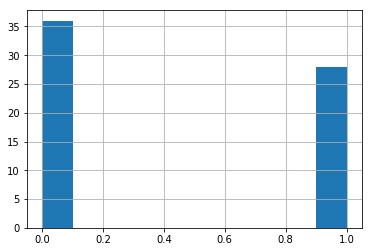

In [37]:
df.iloc[0, :].hist()
plt.show()

In [38]:
# 转为ndarry类型数据
X = df.values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y
, test_size = 0.3
, random_state =0
)

### 可视化化数据

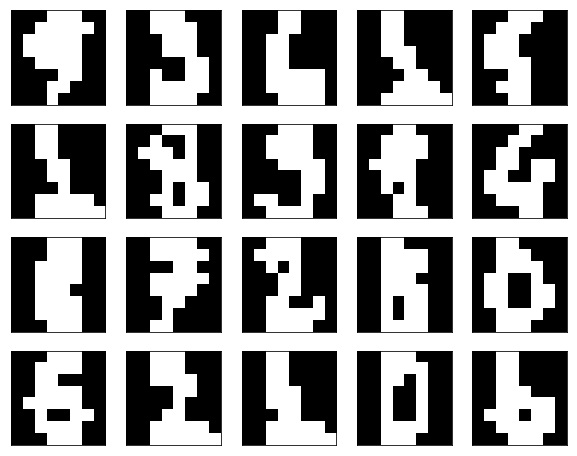

In [39]:
fig, ax = plt.subplots(4, 5
                    , figsize= (10,8)
                    , subplot_kw = {"xticks":[], "yticks":[]}
                    )

for i ,ax in enumerate(ax.flat):
    ax.imshow(Xtrain[i, :].reshape(8, 8)
            ,cmap="gray"
            )
plt.show()

### ⻉叶斯算法

In [47]:
class NaivaBayes:
    """最⼩⻛险朴素⻉叶斯"""
    def __init__(self, alpha=1, fit_prior=True, class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior # 先验
        self.classes = None # 类别
        self.conditional_prob = None # 类条件概率（特征独⽴性假设）
        
    def calculate_feature_prob(self, feature):
        values = np.unique(feature) # 特征的可能取值
        total_num = float(len(feature))
        value_prob = {}
        for v in values:
            value_prob[v] = ((np.sum(np.equal(feature, v))
                                + self.alpha)/(total_num + len(values)*self.alpha))
        # 填充⾮零项
        if 1.0 not in value_prob.keys():
            value_prob[1.0] = 0.0
        if 0 not in value_prob.keys():
            value_prob[0.0] = 0.0
        return value_prob
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        # 计算先验概率
        if self.class_prior == None:
            class_num = len(self.classes)
            if not self.fit_prior: # 如果不设置先验，则将先验概率等分
                self.class_prior = [1.0/class_num for _ in range(class_num)]
            # 统计先验概率
            else:
                self.class_prior = []
                sample_num = float(len(y))
                for c in self.classes:
                    c_num = np.sum(np.equal(c, y))
                    # 加⼊平滑
                    self.class_prior.append((c_num + self.alpha) / (sample_num +
                                            class_num*self.alpha))
        
        # 计算⻉叶斯条件概率
        self.conditional_prob = {}
        # 分别计算每⼀个类别
        for c in self.classes:
            self.conditional_prob[c] = {}
            
            # 计算每⼀个特征
            for i in range(len(X[0])):
                feature = X[np.equal(y, c)][:, i]
            
                # 保存c_j类的f_i类特征
                self.conditional_prob[c][i] = self.calculate_feature_prob(feature)
        return self
    
    def predict_sigle_sample(self, x):
        """最⼩错误的⻉叶斯决策"""
        label = -1
        max_poster_prob = 0
        for c_index in range(len(self.classes)):
            current_class_prior = self.class_prior[c_index] # 取出相应的后验概率
            current_conditional_prob = 1.0 # 当前条件概率
            feature_prob = self.conditional_prob[self.classes[c_index]] #当前类别下的特征概率
            j = 0
            for feature_i in range(len(feature_prob)):
                # 当前类别下的所有的条件概率
                current_conditional_prob *= feature_prob[feature_i][x[j]]
                j += 1
            if current_conditional_prob*current_class_prior>max_poster_prob:
                max_poster_prob = current_class_prior*current_conditional_prob
                label = self.classes[c_index]
        return label
    
    def predict_sigle_expensive(self, x):
        """最⼩⻛险的⻉叶斯决策"""
        label = -1
#         max_poster_prob = 0
        
        current_loss = np.ones((1, len(self.classes)))
        # 使⽤随机的决策⽅程（0， 1）
        decsion_function = np.random.random((len(self.classes), len(self.classes)))
        # decsion_function = np.random.random_integers(10, size=(len(self.classes),
        # len(self.classes)))
        
        for c_index in range(len(self.classes)):
            current_class_prior = self.class_prior[c_index] # 取出相应的后验概率
            current_conditional_prob = 1.0 # 当前条件概率
            feature_prob = self.conditional_prob[self.classes[c_index]] #当前类别下的特征概率
            j = 0
            for feature_i in range(len(feature_prob)):
                # 当前类别下的所有的条件概率
                current_conditional_prob *= feature_prob[feature_i][x[j]]
                j += 1
            current_loss[:, c_index] = current_class_prior*current_conditional_prob
        label = np.argmin(np.matmul(decsion_function, current_loss.T))
        return label
    
    def predict_accuacy(self, Xtest, Ytest, decsion=True):
        if decsion:
            if Xtest.ndim == 1:
                return self.predict_sigle_sample(Xtest)
            else:
                count = 0
                labels = []
                for i in range(Xtest.shape[0]):
                    label = self.predict_sigle_sample(Xtest[i])
                    if label == Ytest[i]:
                        count +=1
                    labels.append(label)
                return count/Xtest.shape[0], np.array(labels)
        else:
            if Xtest.ndim == 1:
                return self.predict_sigle_expensive(Xtest)
            else:
                count = 0
                labels = []
                for i in range(Xtest.shape[0]):
                ##最⼩错误的⻉叶斯
                    label = self.predict_sigle_expensive(Xtest[i])
                    if label == Ytest[i]:
                        count +=1
                    labels.append(label)
                return count/Xtest.shape[0], np.array(labels)

In [48]:
model = NaivaBayes()
model = model.fit(Xtrain,Ytrain)

### 最⼩错误的⻉叶斯

In [49]:
# 单个样本的测试
model.predict_sigle_sample(Xtest[0])

2

In [52]:
accuracy, Ypred = model.predict_accuacy(Xtest, Ytest)
print("Accuracy:%0.3f" % (accuracy))

Accuracy:0.863


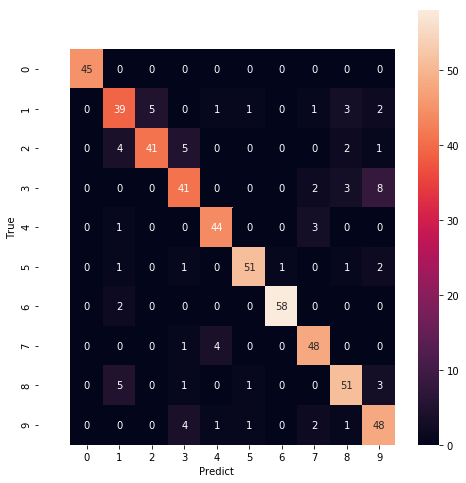

In [53]:
cm = confusion_matrix(Ytest, Ypred)
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cm, annot=True, ax = axes)
axes.set_xlabel("Predict")
axes.set_ylabel("True")
axes.set_xlim([-1,10])
axes.set_ylim([10,-1])
plt.show()

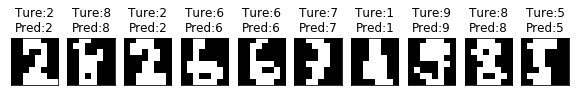

In [54]:
fig, ax = plt.subplots(1, 10
                        , figsize= (10,10)
                        , subplot_kw = {"xticks":[], "yticks":[]}
                        , squeeze = False
                        )
for i ,ax in enumerate(ax.flat):
    ax.imshow(Xtest[i, :].reshape(8, 8)
    ,cmap="gray"
    )
    ax.set_title("Ture:{}\nPred:{}".format(Ytest[i], Ypred[i]))
plt.show()

### 最⼩⻛险的⻉叶斯

In [55]:
# 单个样本的决策
model.predict_sigle_expensive(Xtest[0])

8

In [56]:
#测试集预测(基于最⼩⻛险的⻉叶斯，取决与不同的决策⾯⽅程，此次决策⾯⽅程随机抽取，所以准确率较低，可
#以进⾏⼈为调节)
accuracy, Ypred = model.predict_accuacy(Xtest, Ytest, decsion=False)
print("Accuracy:%0.3f" % (accuracy))

Accuracy:0.119


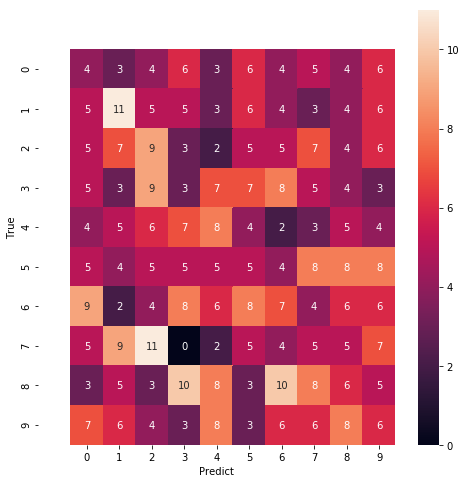

In [57]:
# 混淆矩阵
cm = confusion_matrix(Ytest, Ypred)
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cm, annot=True, ax = axes)
axes.set_xlabel("Predict")
axes.set_ylabel("True")
axes.set_xlim([-1,10])
axes.set_ylim([10,-1])
plt.show()

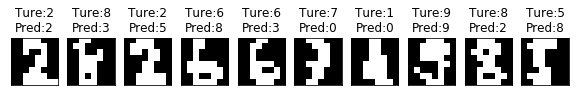

In [58]:
fig, ax = plt.subplots(1, 10
                        , figsize= (10,10)
                        , subplot_kw = {"xticks":[], "yticks":[]}
                        , squeeze = False
                        )
for i ,ax in enumerate(ax.flat):
    ax.imshow(Xtest[i, :].reshape(8, 8)
    ,cmap="gray"
    )
    ax.set_title("Ture:{}\nPred:{}".format(Ytest[i], Ypred[i]))
plt.show()